# Ch 6. Mixture Models

1. Finite mixture models
2. Infinite mixture models
3. Continuous mixture models

In [1]:
from pathlib import Path

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import seaborn as sns
import theano.tensor as tt
from scipy import stats

gg.theme_set(gg.theme_minimal())
%config InlineBackend.figure_format = 'retina'

## Mixture models (MM)

- occurs when the population is a combination of sub-populations
- do not really have to believe there are sub-populations
    - can be used as a trick to add flexibility to the model

## Finite mixture models

- a finite weighted mixture of two or more distributions
- the probability density of the observed data is a weighted sum of the probability density for $K$ subgroups
    - $w_i$: wieght of each subgroup (a.k.a component); the probability of component $i$
    - $\Pr(y|\theta)_i$: distribution of the subgroup $i$

$$
\Pr(y|\theta) = \sum_{i=1}^{K} w_i \Pr_i(y | \theta_i)
$$

- to solve a MM, need to properly assign each data point to one of the components
    - introduce a random variable $z$ that specifies to which component an observation belongs
        - called a *latent* variable
- example using chemical shift data (from protein NMR)

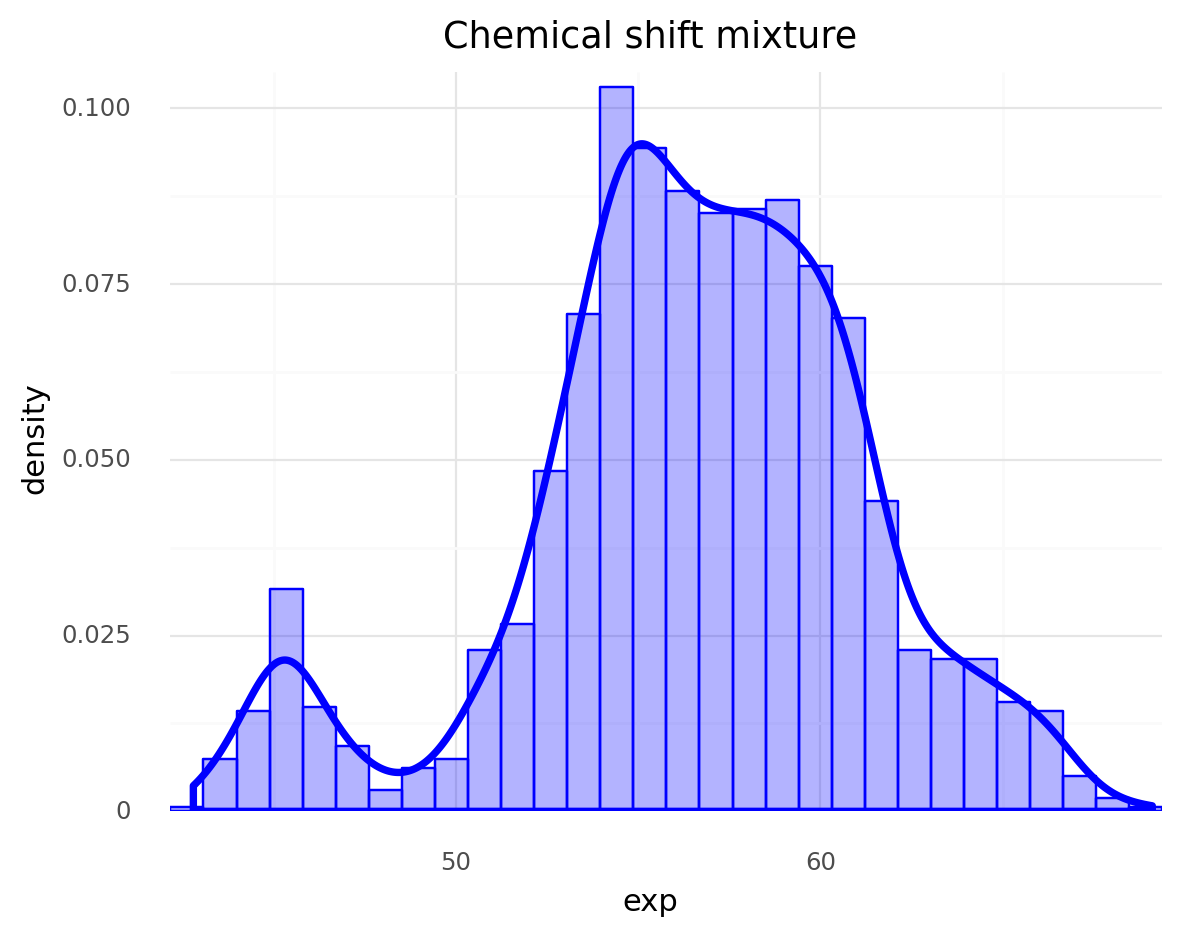

<ggplot: (8768203148373)>

In [2]:
cs = pd.read_csv(Path("data/chemical_shifts_theo_exp.csv"))
cs_exp = cs["exp"]

(
    gg.ggplot(cs, gg.aes("exp"))
    + gg.geom_histogram(
        gg.aes(y="..density.."), bins=30, alpha=0.3, fill="blue", color="blue"
    )
    + gg.geom_density(color="blue", size=1.5)
    + gg.scale_x_continuous(expand=(0, 0))
    + gg.scale_y_continuous(expand=(0, 0, 0.02, 0))
    + gg.labs(x="exp", y="density", title="Chemical shift mixture")
)

### The categorical distribution

- most general discrete distribution
- parameterized using a parameter specifying the probabilities of each possible outcome

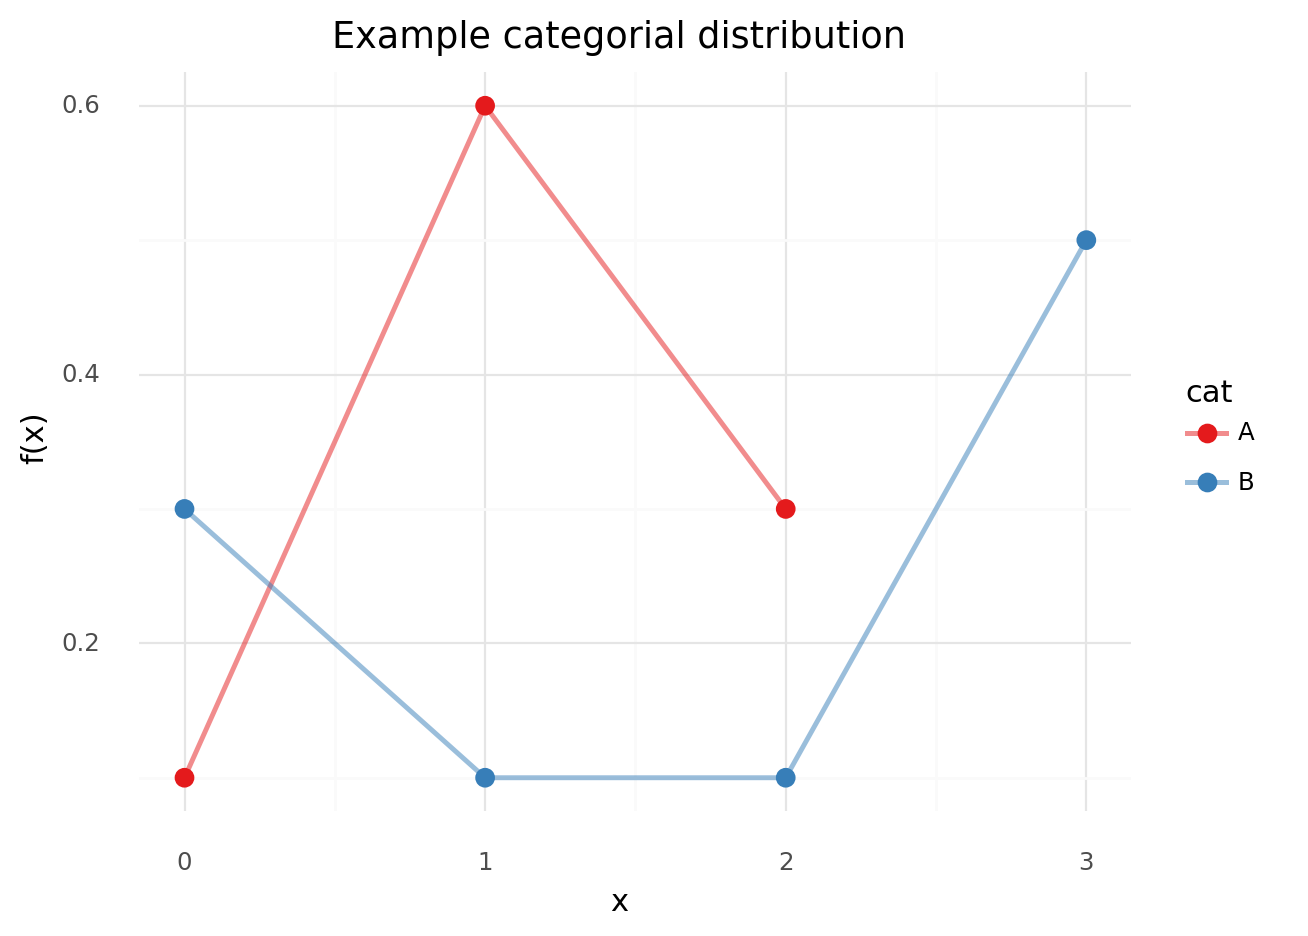

<ggplot: (8768201942007)>

In [3]:
example_cat_data = pd.DataFrame(
    {
        "cat": ["A", "A", "A", "B", "B", "B", "B"],
        "y": [0.1, 0.6, 0.3, 0.3, 0.1, 0.1, 0.5],
        "x": [0, 1, 2, 0, 1, 2, 3],
    }
)

(
    gg.ggplot(example_cat_data, gg.aes(x="x", y="y", color="cat"))
    + gg.geom_line(alpha=0.5, size=1)
    + gg.geom_point(size=3)
    + gg.scale_color_brewer(type="qual", palette="Set1")
    + gg.labs(x="x", y="f(x)", title="Example categorial distribution")
)

### The Dirichlet distribution

- the Dirichlet distribution:
    - lives in the *simplex* (an $n$-dim. triangle)
    - output of the dist. is a $K$-length vector $\alpha$
    - output are restricted to be nonnegative and sum to 1
    - generalization of the beta distribution
        - i.e. extend the beta dist. beyond 2 outcomes
        - the beta dist. has two outcomes and returns a 2-element vector: $(p, 1-p)$
        - for 3 outcomes, need a 3-element vector $(p, q, r)$ where $p+q+r=1$
        - for $K$ outcomes, declare a vector $\alpha$ where $||\alpha|| = K$

![](assets/ch06/Dirichlet-triangles.png)

- in a model, use the Dirichlet dist. as a $K$-sided coin flip model on top of a Gaussian estimated model
    - in the diagram, there are $K$ copies of the model in the rounded-rect
    - $\mu_k$ is dependent upon the group $k$
    - $\sigma_\mu$ and $\sigma_\sigma$ are shared for all groups

![](assets/ch06/Dirichlet-prior-mixture-model.png)

In [4]:
# NOTE: We expect this  model to fit poorly.
# See below for an example of how to reparameterize for a more
# effective fitting process.

clusters = 2

with pm.Model() as model_kg:
    p = pm.Dirichlet("p", a=np.ones(clusters))
    z = pm.Categorical(
        "z", p=p, shape=len(cs.exp)
    )  # group assignment; one per data point
    means = pm.Normal("means", mu=cs.exp.mean(), sd=10, shape=clusters)
    sd = pm.HalfNormal("sd", sd=10)

    y = pm.Normal("y", mu=means[z], sd=sd, observed=cs.exp)
    # trace_kg = pm.sample()  # NOT RUN BECAUSE TOOOOOOO SLOW

- the above model fits poorly because the latent variable `z` is explcitly included
- reparameterize:
    - in a MM, the observed vairable $y$ is conditional on the latent variable $z$, that is $\Pr(y|z, \theta)$
    - can consider $z$ is nuisance variable and marginalize to get $\Pr(y | \theta)$
    - can do this in PyMC3 using the `NormalMixture()` distribution to get a Gaussian mixture model

In [5]:
clusters = 2

with pm.Model() as model_mg:
    p = pm.Dirichlet("p", a=np.ones(clusters))
    means = pm.Normal("means", mu=cs.exp.mean(), sd=10, shape=clusters)
    sd = pm.HalfNormal("sd", sd=10)

    y = pm.NormalMixture("y", w=p, mu=means, sd=sd, observed=cs.exp)

    trace_mg = pm.sample(random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, means, p]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 25 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [6]:
az_trace_mg = az.from_pymc3(trace_mg, model=model_mg)

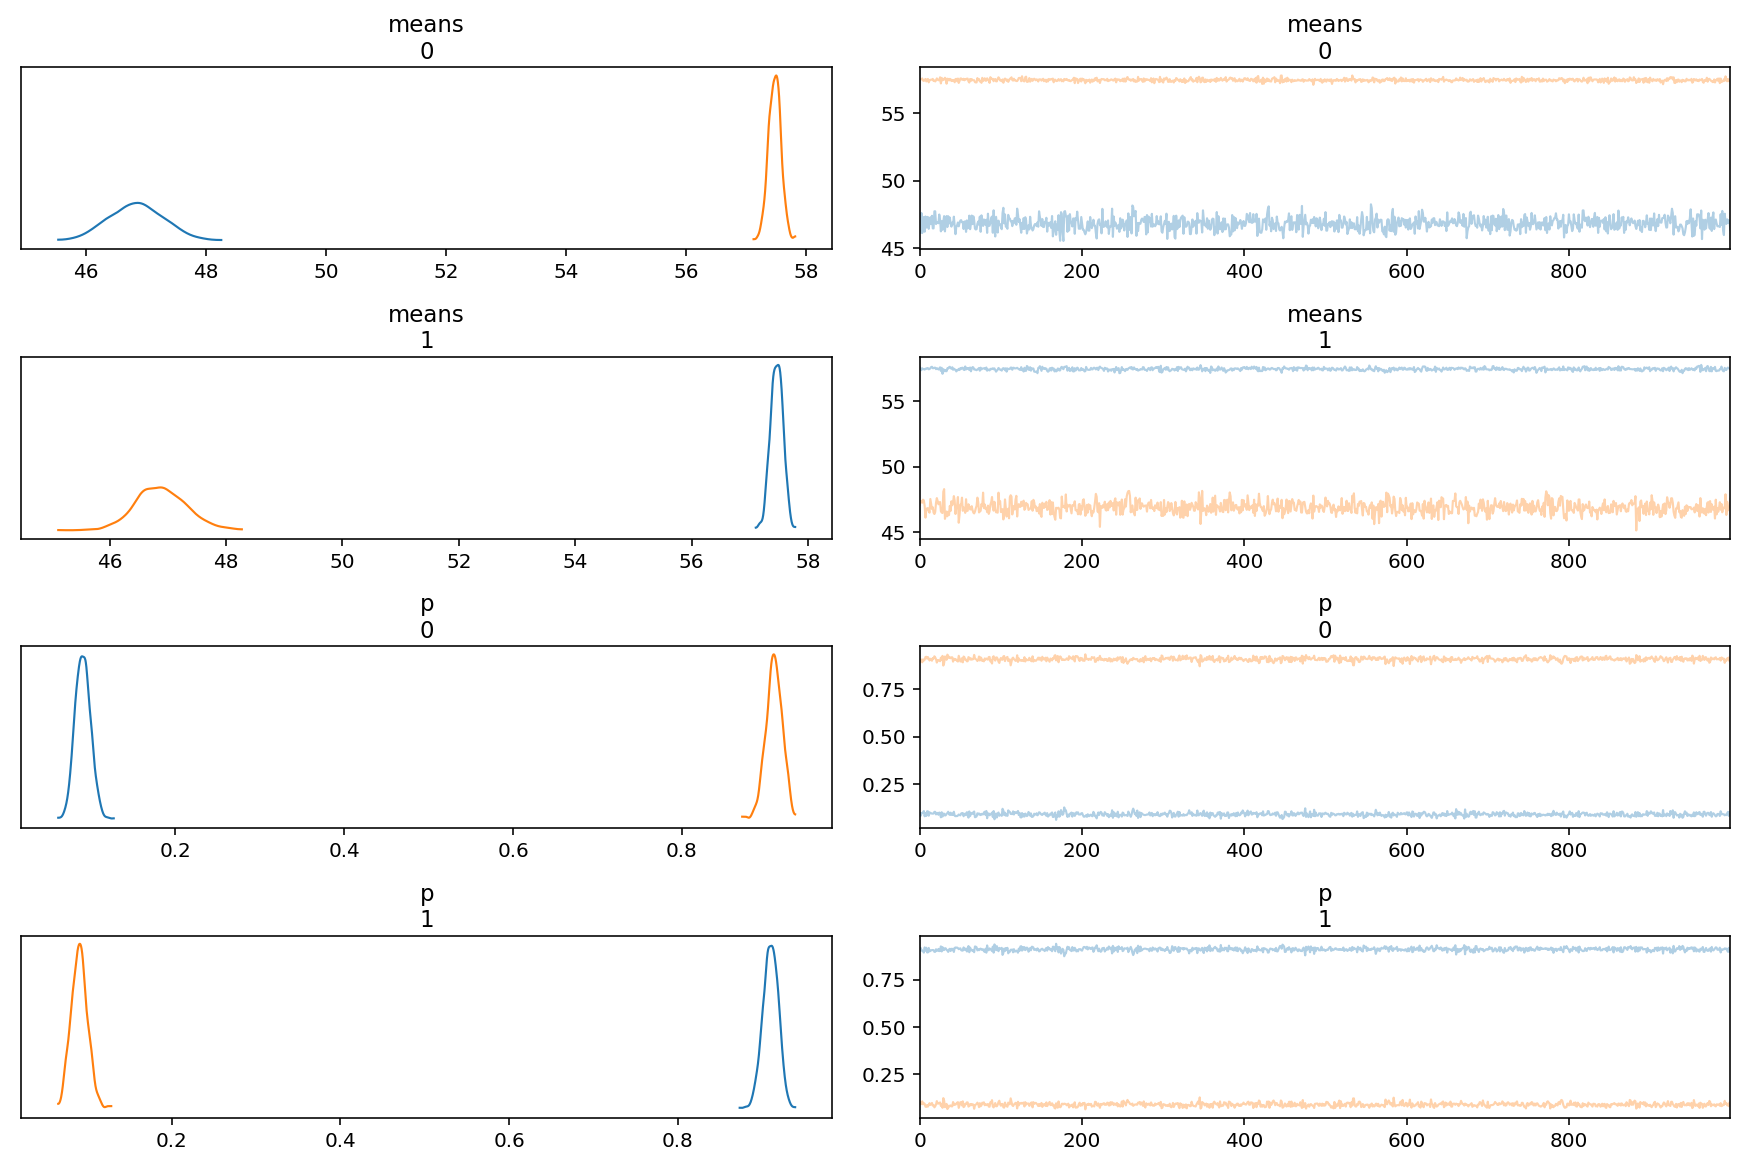

In [7]:
az.plot_trace(az_trace_mg, var_names=["means", "p"])
plt.show()

In [8]:
az.summary(trace_mg, var_names=["means", "p"])

/usr/local/Caskroom/miniconda/base/envs/bayesian-analysis-with-python_e2/lib/python3.9/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
means[0],52.154,5.329,46.242,57.681,3.747,3.169,2.0,2.0,3.0,63.0,1.83
means[1],52.174,5.299,46.358,57.664,3.726,3.152,2.0,2.0,3.0,61.0,1.83
p[0],0.500,0.410,0.076,0.924,0.288,0.244,2.0,2.0,3.0,93.0,1.83
p[1],0.500,0.410,0.076,0.924,0.288,0.244,2.0,2.0,3.0,93.0,1.83


### Non-identifiability of mixture models

- looking at the trace plots and summary table above, notive that the distributions for *both* means and both $p$ are bimodal and that the average values for these parameters are the same
    - caused by **parameter non-identifiability** because can make multiple different models where one mean is the either mode and the other is the remaining mode (and the same for $p$)
    - in mixture models, also known as **lbel-switching problem**
    - two ways to prevent non-identifiability in MM:
        1. force the component sto be ordered (e.g. arrange the means of the components in increasing order)
        2. use informative priors
- in PyMC3, can add `pm.potential()` to the likelihood of the model
    - is an arbitrary factor that does not necessarily depend on the data
    - thus, does not add any parameters to the model
    - example of adding a constraing to a model:
        - if the constraint is not violation, add 0 to the likelihood
        - if is violated, add $-\infty$ to make the outcome impossible
        - thus, the model considers parameters that violate the constraints to be impossible without affecting the rest of the values

In [9]:
clusters = 2

with pm.Model() as model_mgp:
    p = pm.Dirichlet("p", a=np.ones(clusters))
    means = pm.Normal(
        "means", mu=np.array([0.9, 1]) * cs_exp.mean(), sd=10, shape=clusters
    )
    sd = pm.HalfNormal("sd", sd=10)
    order_means = pm.Potential(
        "order_means", tt.switch(means[1] - means[0] < 0, -np.inf, 0)
    )
    y = pm.NormalMixture("y", w=p, mu=means, sd=sd, observed=cs_exp)
    trace_mgp = pm.sample(1000, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, means, p]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 26 seconds.


/usr/local/Caskroom/miniconda/base/envs/bayesian-analysis-with-python_e2/lib/python3.9/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.


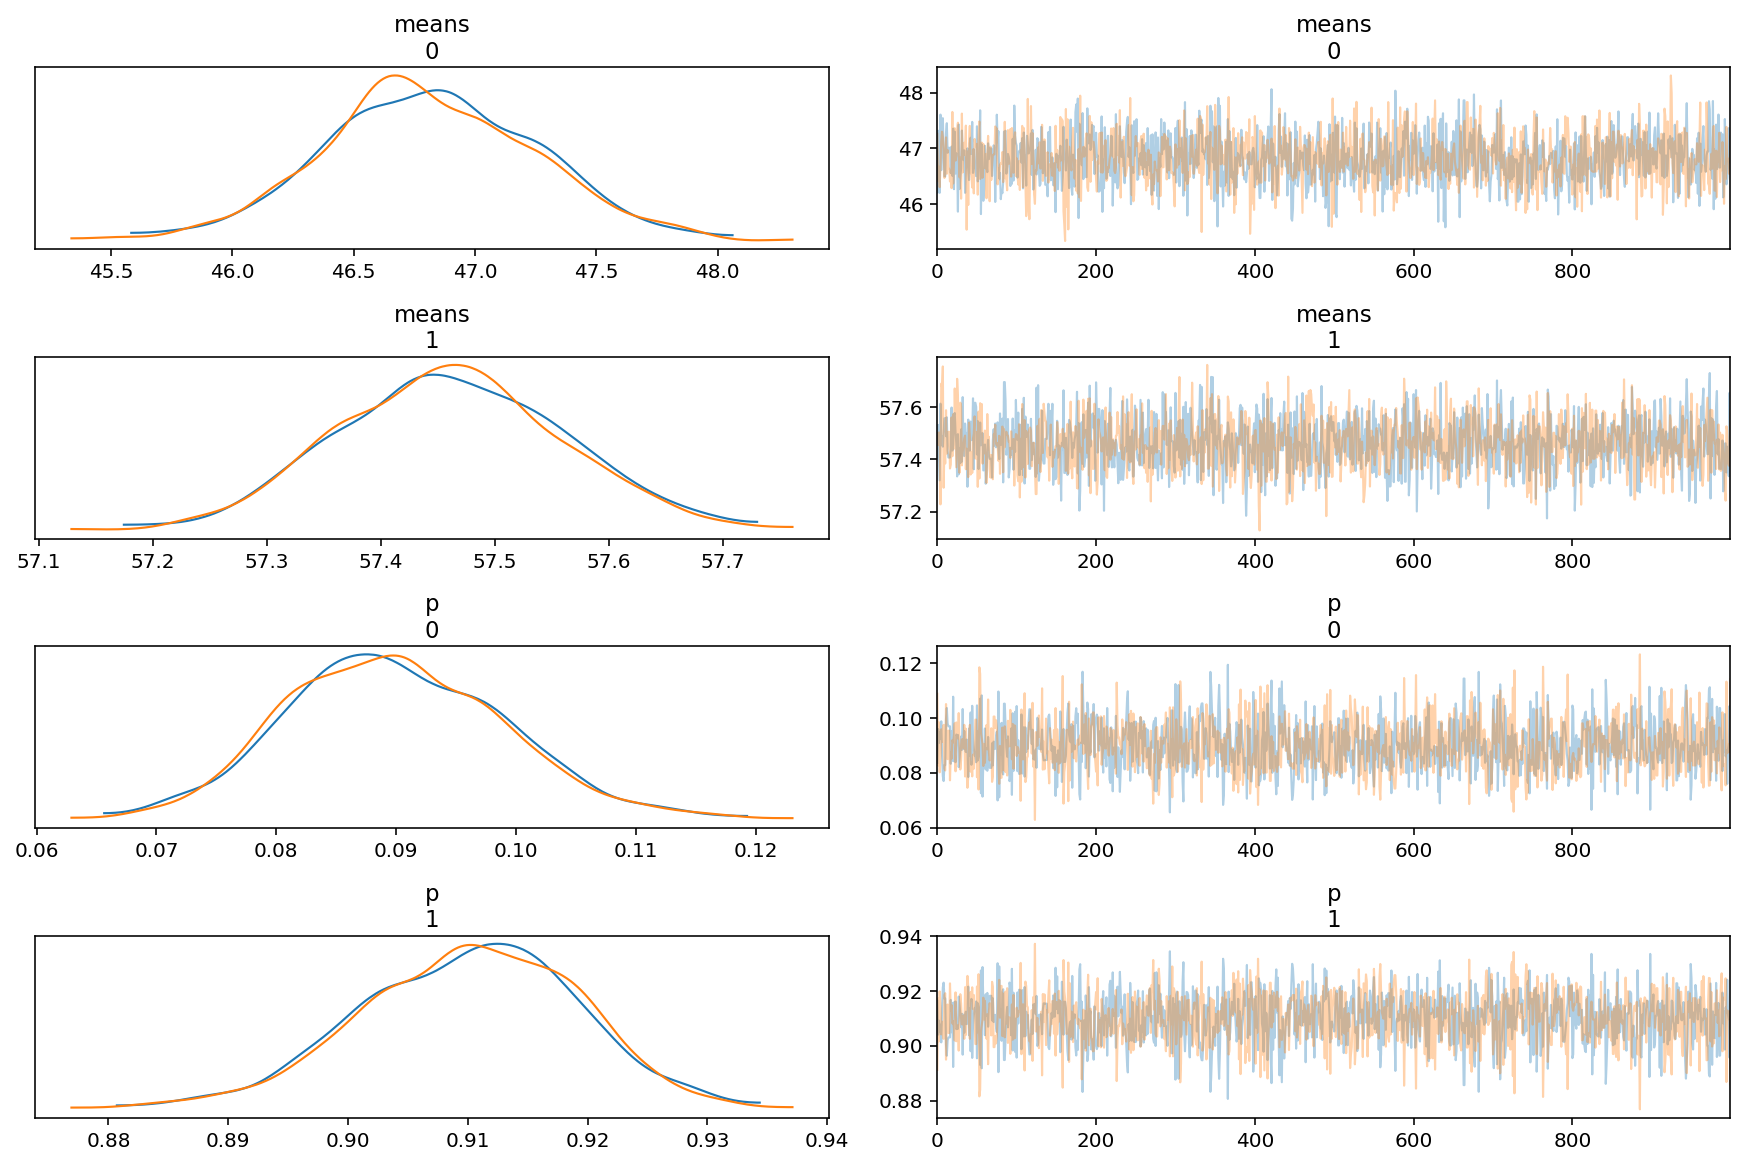

In [10]:
varnames = ["means", "p"]
az.plot_trace(trace_mgp, varnames)
plt.show()

In [11]:
az.summary(trace_mgp)

/usr/local/Caskroom/miniconda/base/envs/bayesian-analysis-with-python_e2/lib/python3.9/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
means[0],46.811,0.438,46.040,47.687,0.009,0.007,2185.0,2185.0,2188.0,1432.0,1.0
means[1],57.461,0.098,57.290,57.650,0.002,0.001,2255.0,2255.0,2253.0,1686.0,1.0
p[0],0.090,0.009,0.072,0.106,0.000,0.000,1818.0,1818.0,1804.0,1639.0,1.0
p[1],0.910,0.009,0.894,0.928,0.000,0.000,1818.0,1817.0,1804.0,1639.0,1.0
sd,3.651,0.074,3.506,3.788,0.002,0.001,2236.0,2222.0,2267.0,1619.0,1.0


- can also add a constraint to ensure that each component has a non-null probability
    - i.e. that each component gets at least one observation

```python
min_p = 0.01
p_min = pm.Potential("p_min", tt.switch(tt.min(p) < min_p, -np.inf, 0))
```

### How to choose K

- general advice: start small and increase to imprive model-fit
- example: compare fit of model with $K = \{3, 4, 5, 6\}$

In [12]:
clusters = [3, 4, 5, 6]

models = []
traces = []

for cluster in clusters:
    with pm.Model() as model:
        p = pm.Dirichlet("p", a=np.ones(cluster))
        means = pm.Normal(
            "means",
            mu=np.linspace(cs_exp.min(), cs_exp.max(), cluster),
            sd=10,
            shape=cluster,
            transform=pm.distributions.transforms.ordered,
        )
        sd = pm.HalfNormal("sd", sd=10)

        y = pm.NormalMixture("y", w=p, mu=means, sd=sd, observed=cs_exp)
        trace = pm.sample(1000, tune=2000, random_seed=123)

        traces.append(trace)
        models.append(model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, means, p]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 60 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, means, p]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 57 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, means, p]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 95 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, means, p]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 144 seconds.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


- to show how $K$ affects inference, compare these models' fits with the one from kernel density estimation

In [13]:
trace = traces[0]


def sample_ppc(trace, x_):
    idx = np.random.randint(0, len(trace))
    means_y = trace["means"][idx]
    p_y = trace["p"][idx]
    sd = trace["sd"][idx]
    dist = stats.norm(means_y, sd)
    y = np.sum(dist.pdf(x_) * p_y, 1)
    return y


def sample_ppcs(trace, x, n_clusters, n=50):
    x_ = np.array([x] * n_clusters).T
    data = {i: sample_ppc(trace, x_) for i in range(n)}
    data = pd.DataFrame(data)
    data["x"] = x
    data = data.melt(id_vars="x", var_name="sample_idx", value_name="y")
    return data


def sample_ppc_per_cluster(trace, x, n_clusters):
    x_ = np.array([x] * n_clusters).T
    means_y = trace["means"].mean(0)
    p_y = trace["p"].mean(0)
    sd = trace["sd"].mean(0)
    dist = stats.norm(means_y, sd)
    y = dist.pdf(x_) * p_y
    data = pd.DataFrame(y)
    data["x"] = x
    data = data.melt(id_vars="x", var_name="cluster", value_name="y")
    data["cluster"] = data["cluster"].astype(str)
    return data

In [14]:
def plot_mixture_model_ppc(sampled_ppc, cluster_ppc, n_clusters):
    summary_ppc_df = sampled_ppc.groupby("x").mean().reset_index(drop=False)
    p = (
        gg.ggplot(sampled_ppc, gg.aes(x="x", y="y"))
        + gg.geom_line(gg.aes(group="sample_idx"), alpha=0.2, color="#1075B7")
        + gg.geom_line(data=summary_ppc_df, color="#004B8D", size=1, linetype="--")
        + gg.geom_line(gg.aes(group="cluster"), data=cluster_ppc, linetype="--")
        + gg.theme(figure_size=(4, 4))
        + gg.labs(
            x="exp",
            y="expected density",
            title=f"Mixture Model with {n_clusters} clusters",
        )
    )
    return p

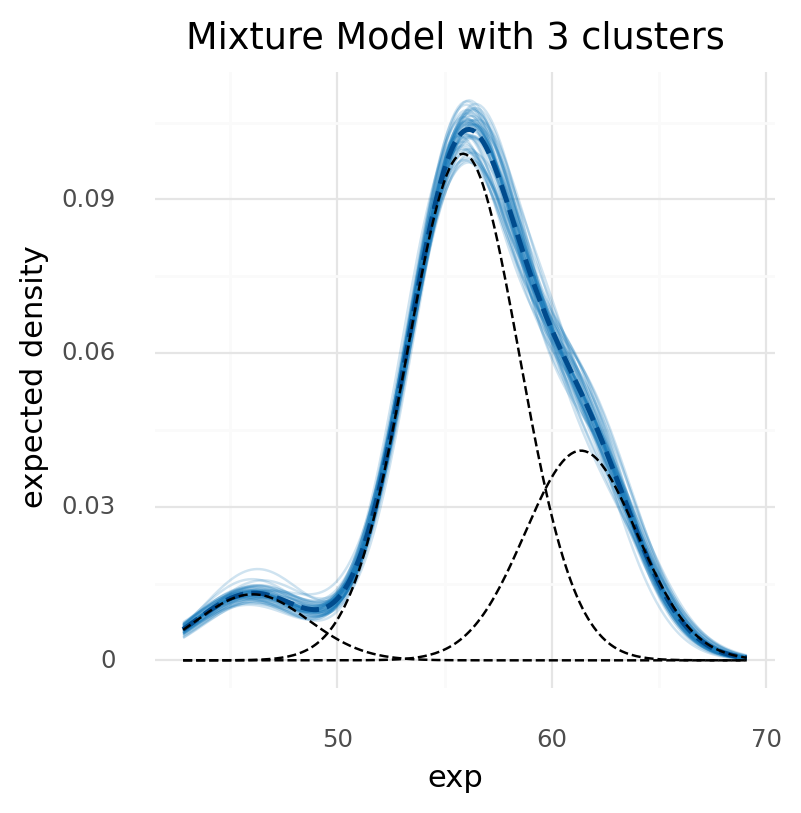

<ggplot: (8768194858867)>


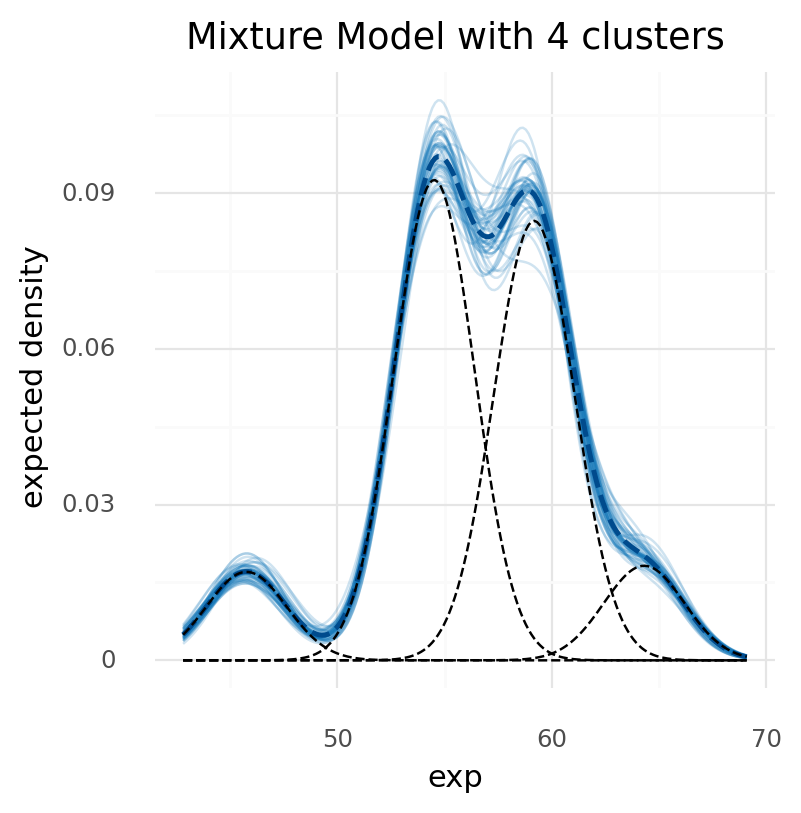

<ggplot: (8768194847061)>


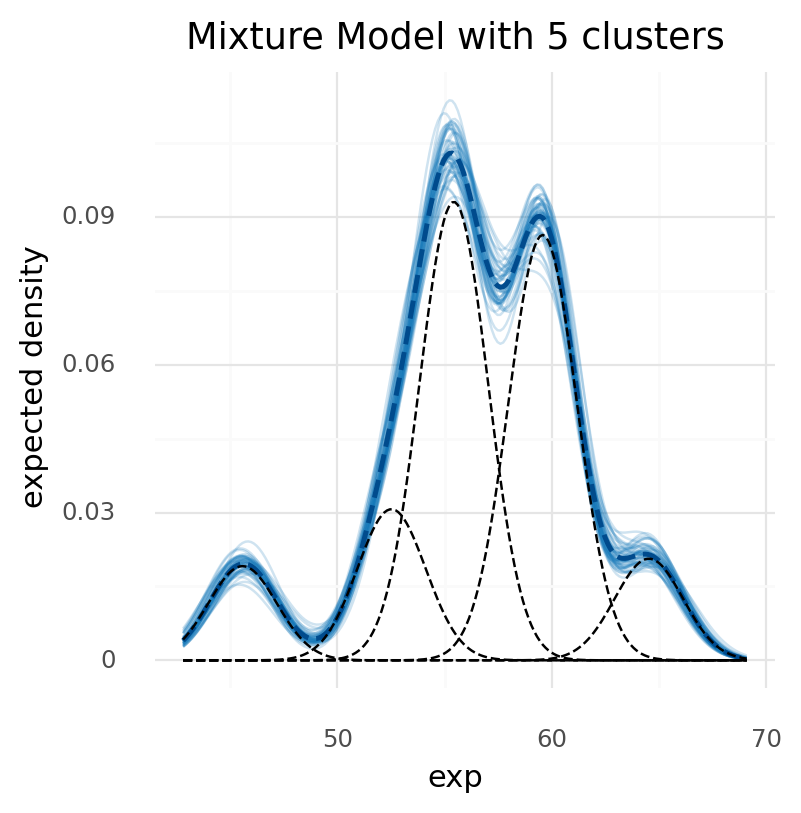

<ggplot: (8768187121661)>


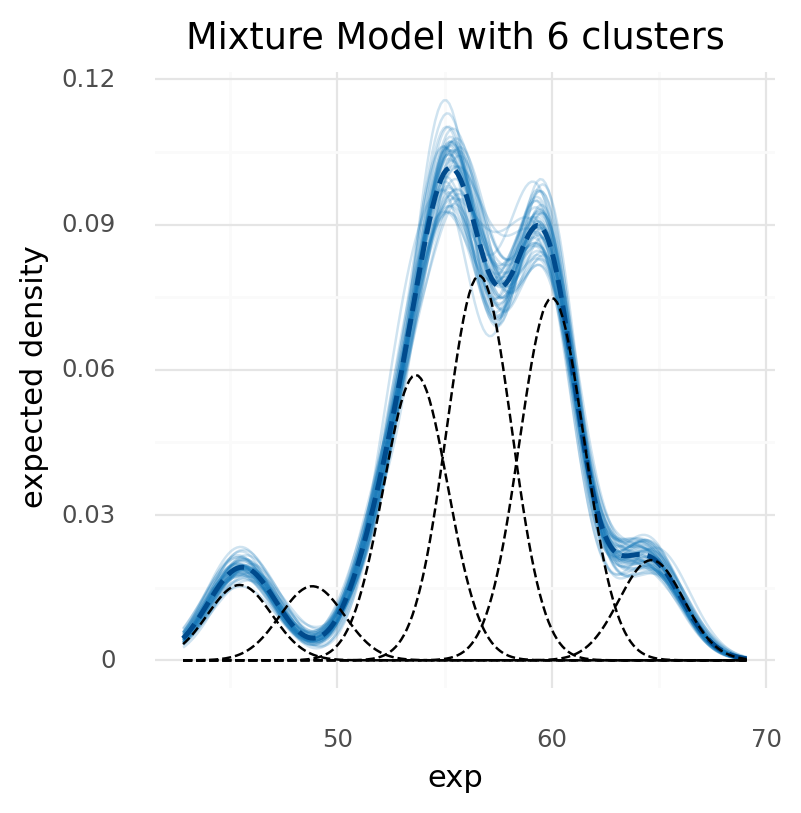

<ggplot: (8768185986055)>


In [15]:
x = np.linspace(cs_exp.min(), cs_exp.max(), 200)
for n_clusters, trace in zip(clusters, traces):
    ppc_df = sample_ppcs(trace=trace, x=x, n_clusters=n_clusters)
    clusters_ppc_df = sample_ppc_per_cluster(trace=trace, x=x, n_clusters=n_clusters)
    print(plot_mixture_model_ppc(ppc_df, clusters_ppc_df, n_clusters))

In [16]:
mm_comparison = az.compare(dict(zip(clusters, traces)), method="BB-pseudo-BMA")
mm_comparison

/usr/local/Caskroom/miniconda/base/envs/bayesian-analysis-with-python_e2/lib/python3.9/site-packages/arviz/stats/stats.py:149: UserWarning: 
The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive accuracy.
/usr/local/Caskroom/miniconda/base/envs/bayesian-analysis-with-python_e2/lib/python3.9/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
/usr/local/Caskroom/miniconda/base/envs/bayesian-analysis-with-python_e2/lib/python3.9/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
6,0,-5127.827401,12.447644,0.000000,0.760694,32.171885,0.000000,False,log
5,1,-5129.245710,9.899071,1.418309,0.235350,31.679818,1.213311,False,log
4,2,-5139.433919,7.436035,11.606518,0.003956,31.277297,4.356708,False,log
3,3,-5178.648194,6.042494,50.820792,0.000000,31.258120,8.935154,False,log


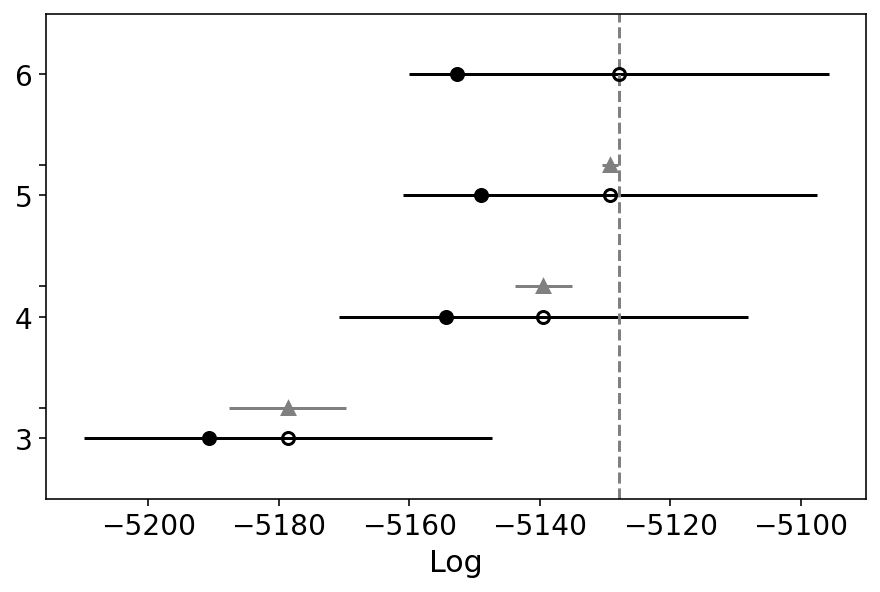

In [17]:
az.plot_compare(mm_comparison)
plt.show()

- from the above plots and table, the mixture model where $K=6$ appears to have the best fit (of the models tested)
    - there is considerable overlap between the models with $K=4, 5, 6$ in the LOO analysis

### Mixture models and clustering

- **model-based clustering**: using a probabilistic model to compute the probability of each data point to belong to each cluster
    - a form of *soft-clustering* (instead of the binary *hard-clustering*)

## Non-finite mixture model
- get the number of clusters from the data using a **Dirichlet process (DP)**

### Dirichlet process

> Non-parametric models are models with a theoretically infinite number of parameters.
In practice, we somehow let the data to reduce the theoretically infinite number of parameters to some finite number, in other words the data decides the actual number of parameters, thus non-parametric models are very flexible.

- DP is the infinite-dimensional generalization of the Dirichlet distribution
    - a single draw (a realization) of a DP is a distribution
    - can use a DAP to assign a prior distribution to a non-fixed number of clusters
        - can think of a DP as a way to sample from a prior distribution of distributions
- some relevant properties of a DP:
    - a DP is a distribution whose realizations are probability distributions
    - is specified by a base distribution $\mathcal{H}$ and a positive real number $\alpha$ called the **concentration parameter**
    - $\mathcal{H}$ is the expected value of the DP
    - as $\alpha$ increased, the realizations become less concentrated
    - on the limit $\alpha \to \infty$ the realizations from a DP will match those of the base distribution; thus if the base distribution is continuous, the DP will be continuous; this is *very rare* in practice
    - in practice, the DP almost always generates a discrete distribution
- can define a distribution by providing the probability $y$ of each possible value $x$
    - the values for $x$ are determined by the type of distribution (e.g. a Gaussian is all real numbers, a Poisson are nonnegative real integers)
    - the values for $y$ (must sum to 1) are generated using a *Gedankenexperiment* known as the **stick-breaking process**
        - break a stick into 2 parts, break one of those pieces in 2, and so on for $K$ times
        - $\alpha$ determines how small we break the sticks (larger $\alpha$ means smaller pieces and $\alpha \to \infty$ means breaking the stick into infinite pieces
        - the following plot shows four results of this process from four different  values of $\alpha$ (an explanation of the function `stick_breaking_truncated()` is provided later)

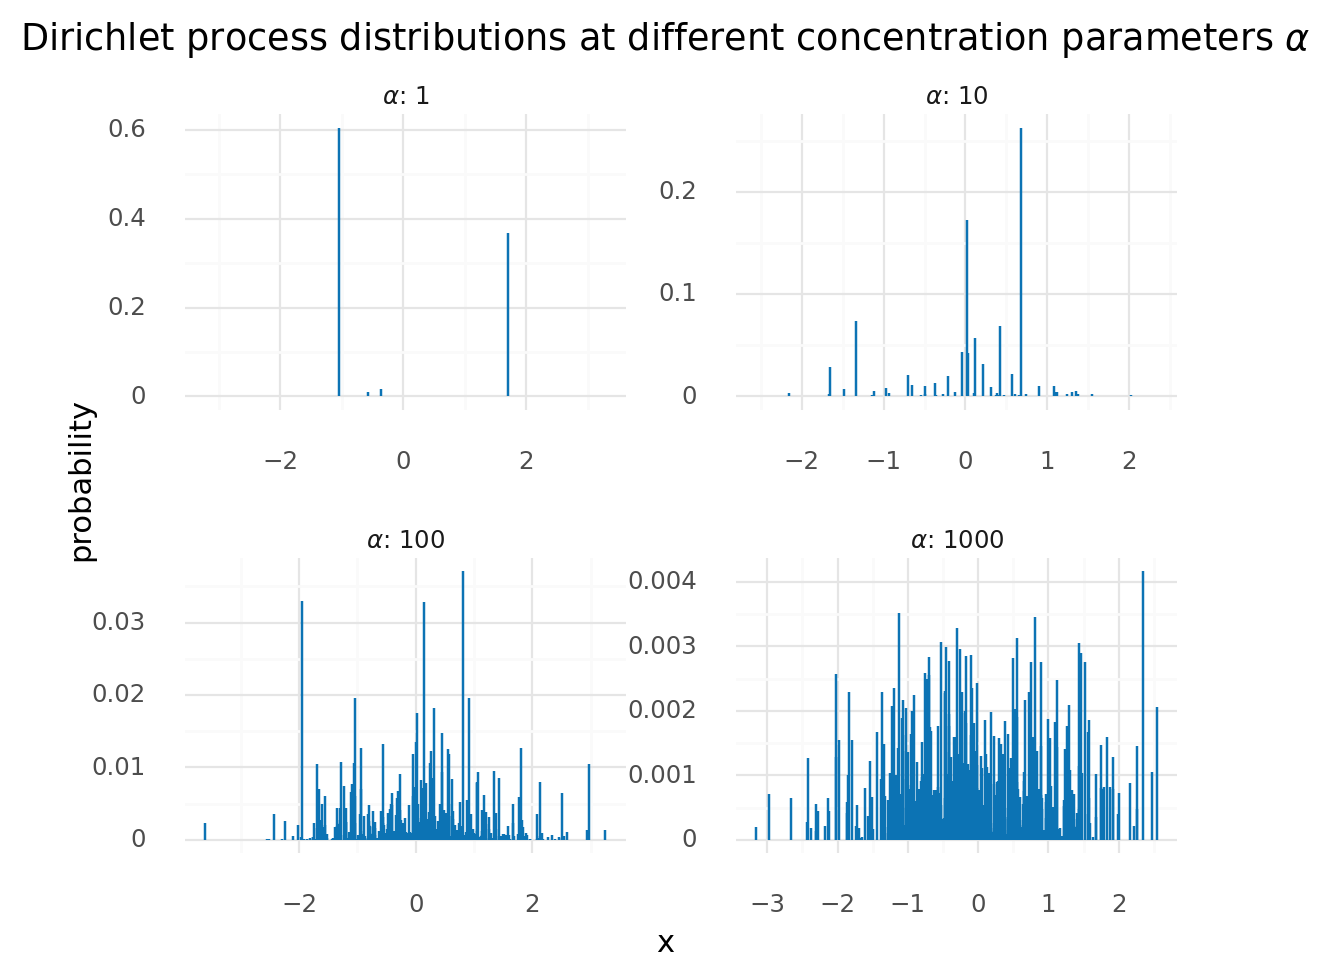

<ggplot: (8768172816788)>

In [43]:
def stick_breaking_truncated(alpha, H, K):
    betas = stats.beta.rvs(1, alpha, size=K)
    w = np.empty(K)
    w = betas * np.concatenate(([1.0], np.cumprod(1 - betas[:-1])))
    locs = H.rvs(size=K)
    return locs, w


K = 500
H = stats.norm  # DP base distribution: Gaussian normal
alphas = [1, 10, 100, 1000]
stick_break_res = None
for idx, alpha in enumerate(alphas):
    locs, w = stick_breaking_truncated(alpha, H, K)
    data = pd.DataFrame({"locs": locs, "w": w, "alpha": f"$\\alpha$: {alpha}"})
    if stick_break_res is None:
        stick_break_res = data
    else:
        stick_break_res = pd.concat([stick_break_res, data])

(
    gg.ggplot(stick_break_res)
    + gg.facet_wrap("alpha", scales="free")
    + gg.geom_linerange(gg.aes(x="locs", ymin=0, ymax="w"), color="#0C73B4")
    + gg.theme(subplots_adjust={"wspace": 0.25, "hspace": 0.5})
    + gg.labs(
        x="x",
        y="probability",
        title="Dirichlet process distributions at different concentration parameters $\\alpha$",
    )
)

- notes on abovbe plot:
    - the DP is a discrete distribution
    - as $\alpha$ increases, the DP pieces get smaller and resemble the base distribution
- the DP places a Gaussian (or whatever base distribution) at the location of each substick of the DP realization and scale/weight that Gaussian by the length of the substick
    - below is an example of that process

In [117]:
alpha = 10
H = stats.norm
K = 5

np.random.seed(124)

x = np.linspace(-4, 4, 250)
locs, w = stick_breaking_truncated(alpha, H, K)
print(f"locations: {locs}")
print(f"weights: {w}")

locations: [ 0.44167705  0.80818623  0.23199239 -1.40035848  0.71590778]
weights: [0.00993163 0.03023728 0.15708906 0.08662139 0.03511271]


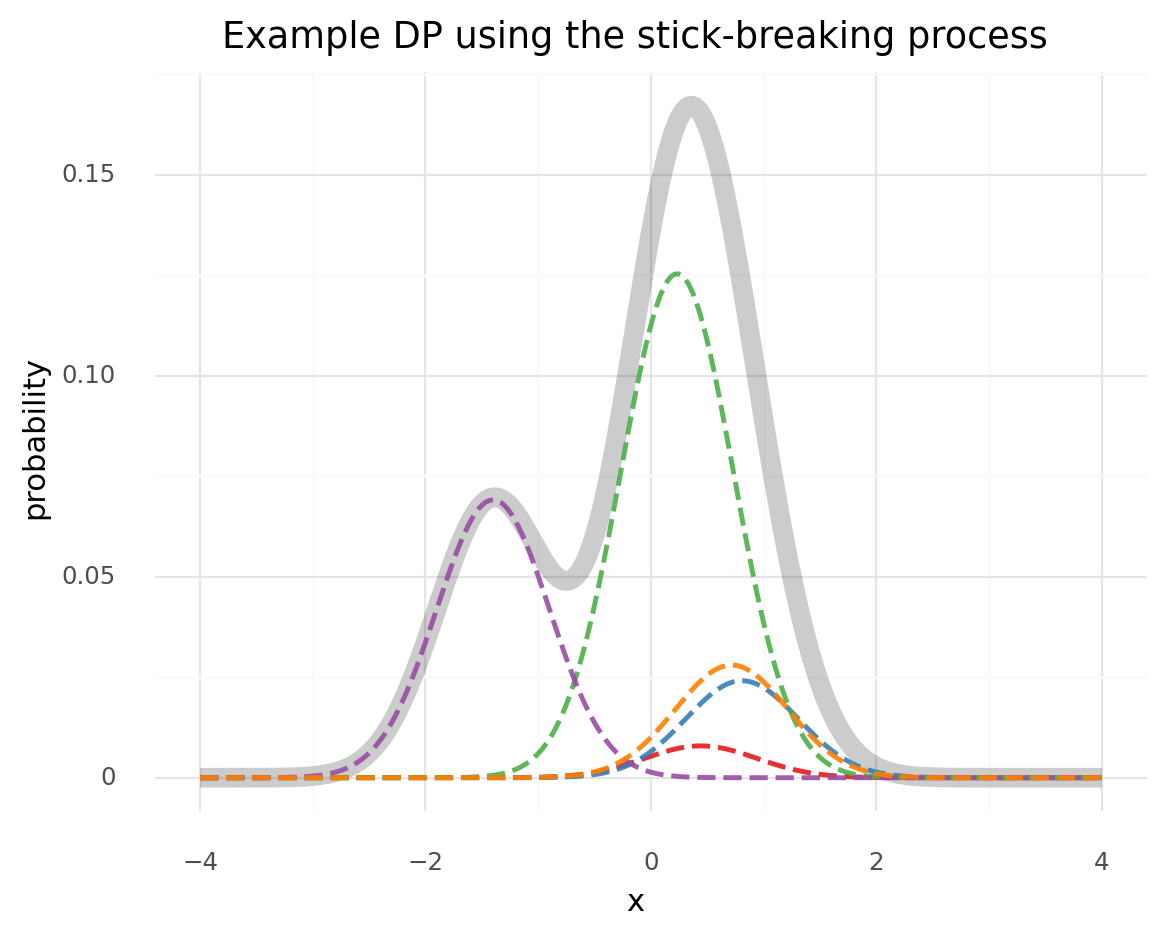

<ggplot: (8768194840510)>

In [122]:
dist = stats.norm(locs, 0.5)
x_ = np.array([x] * K).T  # Make K copies of `x`
prob = dist.pdf(x_) * w
prob_cum = np.sum(prob, 1)

data = pd.DataFrame(prob)
data["x"] = x
data = data.melt(id_vars="x", var_name="peak_idx", value_name="y")
data["peak_idx"] = data["peak_idx"].astype(str)

data_cum = pd.DataFrame({"x": x, "y": prob_cum})

(
    gg.ggplot(data_cum, gg.aes(x="x", y="y"))
    + gg.geom_line(color="black", size=4, alpha=0.2)
    + gg.geom_line(
        gg.aes(color="peak_idx"), data=data, linetype="--", size=1, alpha=0.9
    )
    + gg.scale_color_brewer(type="qual", palette="Set1", guide=False)
    + gg.labs(
        x="x", y="probability", title="Example DP using the stick-breaking process"
    )
)

- explanation of `stick_breaking_truncated()`:

$$
\sum_{k=1}^{\infty} w_k \cdot \delta_{\theta_k}(\theta) = 
\mathcal{f}(\theta) \sim DP(\alpha, \mathcal{H})
$$

- where:
    - $\delta_{\theta_k}$: indicator function that evaluate to 0 everywhere except where $\delta_{\theta_k}(\theta) = 1$; these represent the locations sampled from the base distribution $\mathcal{H}$
    - $w_k$: probabilities given by the following equation

$$
w_k = \beta^{\prime}_{k} \cdot \prod_{i=1}^{k-1} (1-\beta^{\prime}_{i})
$$

- where:
    - $w_k$: length of a substick
    - $\prod_{i=1}^{k-1} (1-\beta^{\prime}_{i})$ is the length of the remaining portion (the part of the stick to keep breaking)
    - $\beta^\prime_k \sim \text{Beta}(1, \alpha)$: indicates how to break the remaining portion
    
- can now try an example in PyMC3
    - need a version of `stick_breaking()` that works with PyMC3
    - also common to define the prior for $\alpha$ as a Gamma distribution

In [127]:
def stick_breaking_pymc3(alpha, K):
    beta = pm.Beta("beta", 1.0, alpha, shape=K)
    w = beta * pm.math.concatenate([[1.0], tt.extra_ops.cumprod(1.0 - beta)[:-1]])
    return w


N = cs_exp.shape[0]
K = 20

with pm.Model() as model:
    alpha = pm.Gamma("alpha", 1.0, 1.0)
    w = pm.Deterministic("w", stick_breaking_pymc3(alpha, K))
    means = pm.Normal("means", mu=cs_exp.mean(), sd=10, shape=K)

    sd = pm.HalfNormal("sd", sd=10, shape=K)
    obs = pm.NormalMixture("obs", w, means, sd=sd, observed=cs_exp.values)

    trace = pm.sample(
        draws=1000, init="advi", n_init=100000, tune=2000, target_accept=0.9
    )

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 56700
Interrupted at 56,699 [14%]: Average Loss = 5,301.7
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, means, beta, alpha]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 1834 seconds.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.
There were 102 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


- the distribution of `alpha` is centered around 0.5 suggesting only a few components were needed by the model

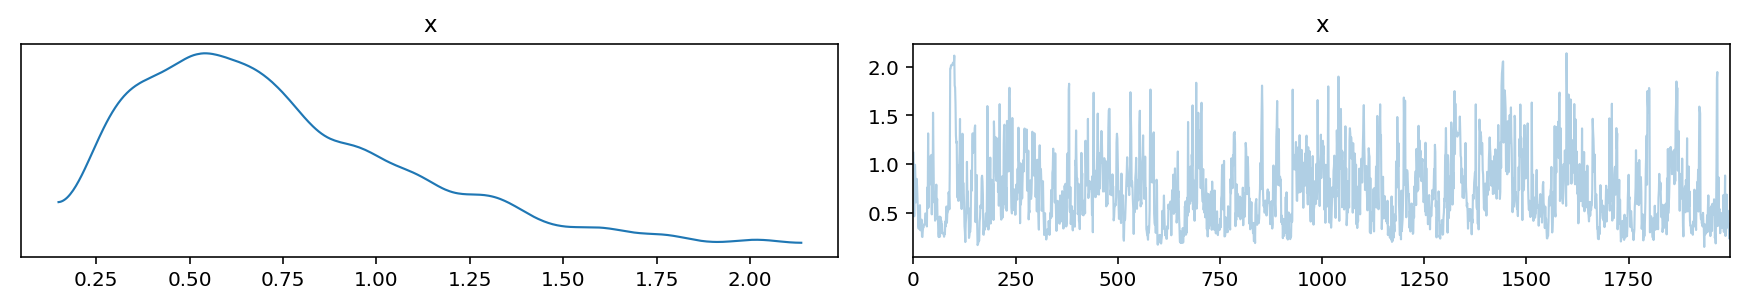

In [141]:
az.plot_trace(trace["alpha"])
plt.show()

- important to check that $K$ was large enough by plotting average weight of each component
    - should be at least a few components with negligible weight

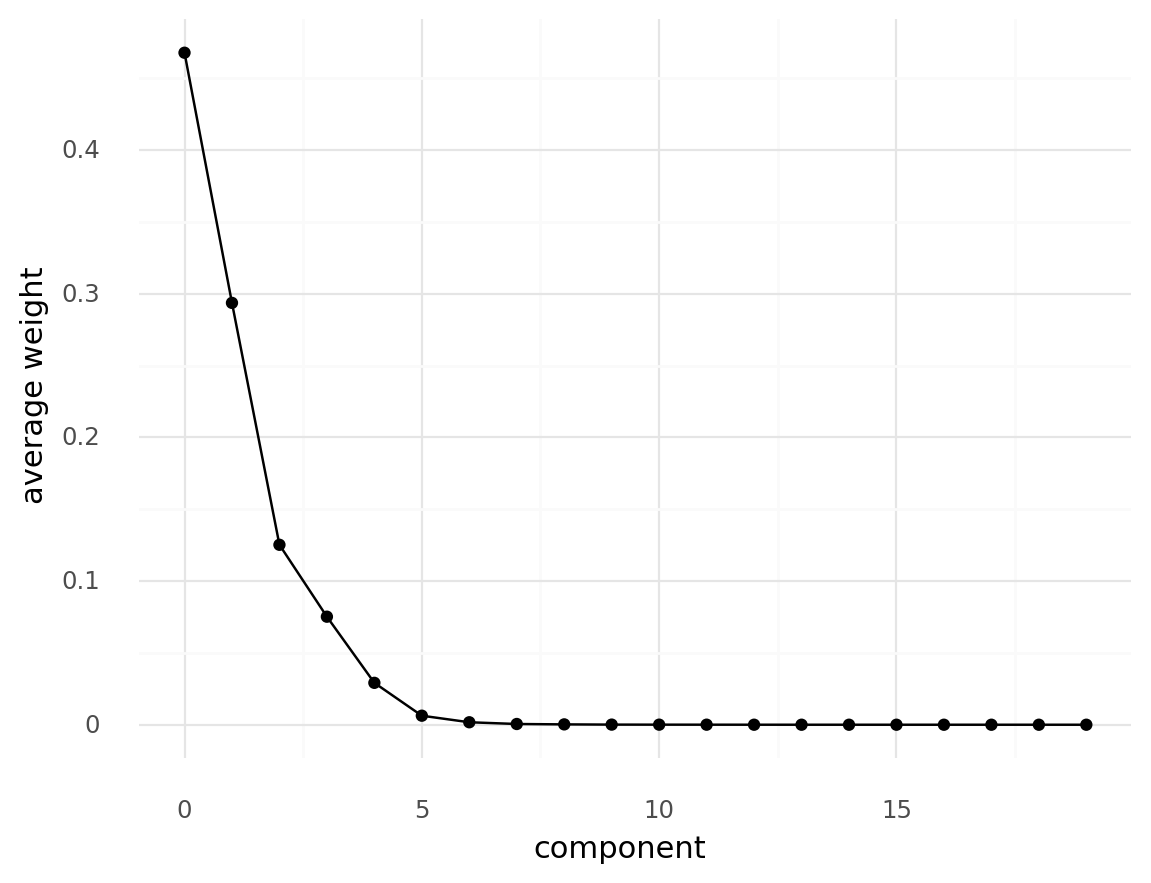

<ggplot: (8768170244455)>

In [132]:
d = pd.DataFrame({"w": np.arange(K), "avg": trace["w"].mean(0)})
(
    gg.ggplot(d, gg.aes(x="w", y="avg"))
    + gg.geom_line()
    + gg.geom_point()
    + gg.labs(x="component", y="average weight")
)

- the plot below shows the posterior predictions of the model

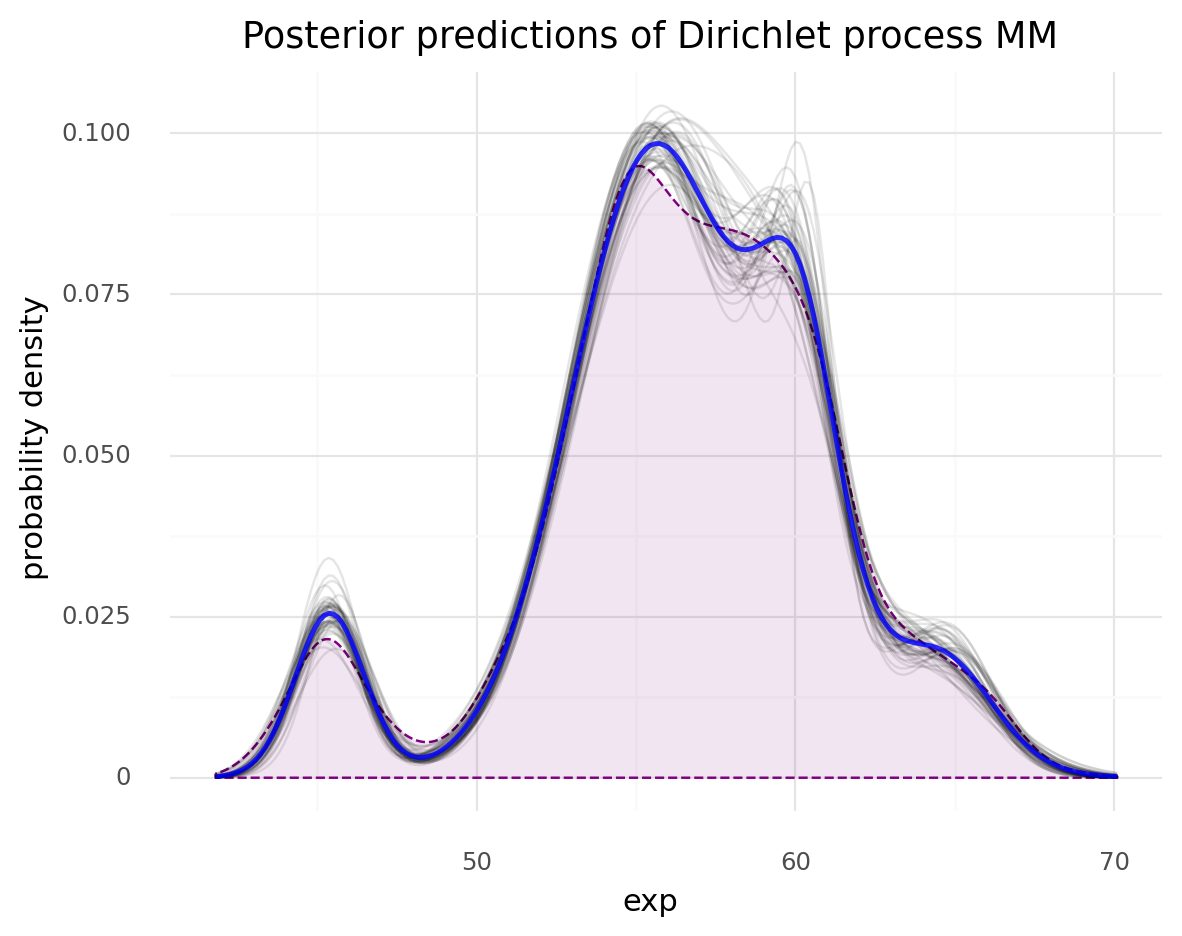

<ggplot: (8768186701370)>

In [188]:
x_plot = np.linspace(cs.exp.min() - 1, cs.exp.max() + 1, 200)

post_pdf_contribs = stats.norm.pdf(
    np.atleast_3d(x_plot),
    trace["means"][:, np.newaxis, :],
    trace["sd"][:, np.newaxis, :],
)
post_pdfs = (trace["w"][:, np.newaxis, :] * post_pdf_contribs).sum(axis=-1)

post_pdfs_df = (
    pd.DataFrame(post_pdfs.T[:, :50])
    .assign(x=x_plot)
    .melt(id_vars="x", var_name="sample_idx")
    .assign(sample_idx=lambda d: d["sample_idx"].astype(str))
)

(
    gg.ggplot(post_pdfs_df)
    + gg.geom_density(
        gg.aes(x="exp"),
        data=cs,
        color="purple",
        fill="purple",
        linetype="--",
        alpha=0.1,
        size=0.5,
    )
    + gg.geom_line(
        gg.aes(x="x", y="value", group="sample_idx"), alpha=0.1, color="black"
    )
    + gg.geom_line(
        gg.aes(x="x", y="value"),
        data=post_pdfs_df.groupby("x").mean().reset_index(drop=False),
        alpha=0.8,
        color="blue",
        size=1,
    )
    + gg.labs(
        x="exp",
        y="probability density",
        title="Posterior predictions of Dirichlet process MM",
    )
)

## Continuous mixtures

---

In [18]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2021-01-05

Python implementation: CPython
Python version       : 3.9.1
IPython version      : 7.19.0

Compiler    : Clang 10.0.0 
OS          : Darwin
Release     : 20.1.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

Hostname: JHCookMac.local

Git branch: master

numpy     : 1.19.4
arviz     : 0.10.0
pymc3     : 3.9.3
matplotlib: 3.3.3
seaborn   : 0.11.1
plotnine  : 0.7.1
pandas    : 1.2.0
scipy     : 1.6.0
theano    : 1.0.5

